In [98]:
from datetime import datetime
from tinkoff.invest import CandleInterval, Client
from tinkoff.invest.schemas import CandleSource
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

from dotenv import load_dotenv
import os

load_dotenv()

True

In [99]:
TOKEN = os.getenv("TOKEN")
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 12, 31)
STOCK = "TCS80A107UL4"
data_candle = []


In [100]:
with Client(TOKEN) as c:
    for candle in c.get_all_candles(
        instrument_id=STOCK,
        from_=start_date,
        to=end_date,
        interval=CandleInterval.CANDLE_INTERVAL_DAY,
        candle_source_type=CandleSource.CANDLE_SOURCE_UNSPECIFIED,
    ):
        data_candle.append({
            'date': candle.time.date(),
            'price': candle.close.units + candle.close.nano / 1e9,
        })

df = pd.DataFrame(data_candle)
df.set_index('date', inplace=True)
df.sort_index(inplace=True)


In [101]:
df["returns"] = np.log(df["price"] / df["price"].shift(1))

In [102]:
lags = 3
train_start = start_date.date()
train_end = train_start + relativedelta(months=9)
test_start = train_end + relativedelta(days=1)
test_end = end_date.date()

print(f"Start train period from {train_start} to {train_end}")
print(f"Start test period from {test_start} to {test_end}")

Start train period from 2025-01-01 to 2025-10-01
Start test period from 2025-10-02 to 2025-12-31


In [103]:
df_train = df[(df.index >= train_start) & (df.index <= train_end)].copy()

cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    df_train[col] = df["returns"].shift(lag)
    cols.append(col)

df_train.dropna(inplace=True)
reg = np.linalg.lstsq(
    df_train[cols],
    np.sign(df_train['returns']),
)[0]

In [104]:
test_df = df[(df.index >= test_start) & (df.index <= test_end)].copy()

cols = []
for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    test_df[col] = df["returns"].shift(lag)
    cols.append(col)

test_df.dropna(inplace=True)
test_df["prediction"] = np.sign(np.dot(test_df[cols], reg))
test_df["strategy"] = test_df["prediction"] * test_df["returns"]


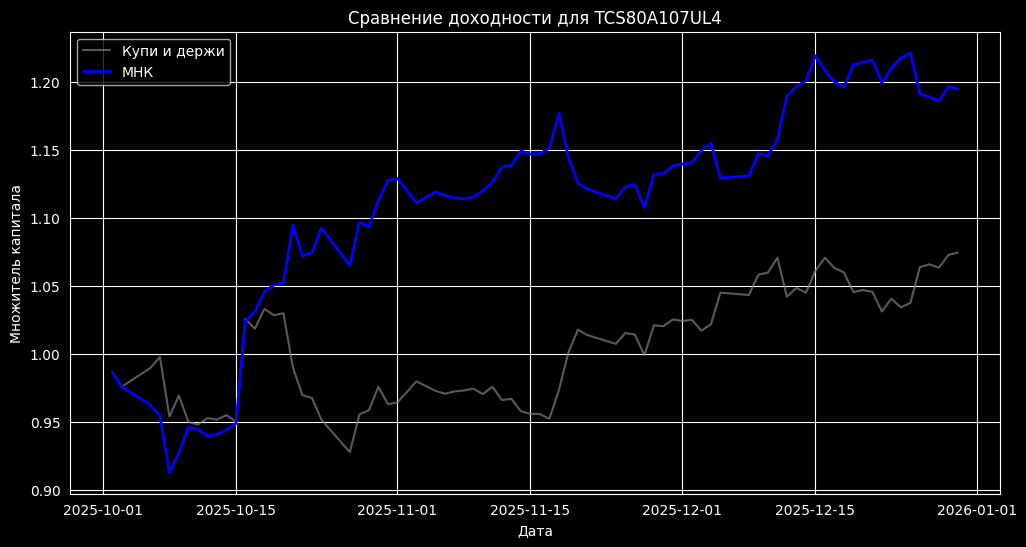

Итоговая доходность актива: 7.46%
Итоговая доходность стратегии: 19.47%


In [105]:
test_df["cum_returns"] = test_df["returns"].cumsum().apply(np.exp)
test_df["cum_strategy"] = test_df["strategy"].cumsum().apply(np.exp)

plt.figure(figsize=(12, 6))
plt.plot(test_df["cum_returns"], label="Купи и держи", color="gray", alpha=0.7)
plt.plot(test_df["cum_strategy"], label="МНК", color="blue", linewidth=2)

plt.title(f"Сравнение доходности для {STOCK}")
plt.xlabel("Дата")
plt.ylabel("Множитель капитала")
plt.legend()
plt.grid(True)
plt.show()

print(f"Итоговая доходность актива: {(test_df['cum_returns'].iloc[-1] - 1):.2%}")
print(f"Итоговая доходность стратегии: {(test_df['cum_strategy'].iloc[-1] - 1):.2%}")